# LDA to Medicinal Food Reviews

by **Bo Tian**

12/05/2020

In this note, I apply Latent Dirichlet Allocation (LDA) to the medicinal food review data set in the Python using Gensim implementation to classify if any given review is about the effectiveness of the product or not. Using this binary filter, we will build a refined item-based medicinal food product recommender system.

## Table of Content

1. [Introduction](#1)
2. [Data Cleaning](#2)
3. [LDA Model Traning](#3)
4. [Effectiveness Filter](#4)
5. [Medicinal Food Recommender Systerm](#5)
6. [Reference](#6)

## 1. Introduction
<a id='1'></a>

### What is LDA?

[Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) an unsupervised machine-learning model that takes a collection of documents as input and finds their topics as output. For theoretic details of LDA, we refer the reader to [the original paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) by David Blei, Andrew Ng and Michael I. Jordan in 2003.

Due to the unsupervised training process, there is no "correct" list of topics to compare against every corpus, hence it is important to identify if a trained model is objectively good or bad. The following approaches are commonly used for model evaluation:

**Eye Balling Models + Human Judgements**
- Top N words
- Topics Differentiation


**Intrinsic Evaluation Metrics**
- Topic Coherence: it measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. 

In this note, we will be using `C_v` measure (implemented in Gensim) based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity.

## 2. Data Preprocessing
<a id='2'></a>

### Install dependent packages

In [1]:
# To be run only once
if 0 == 1:
    !pip install gensim
    !pip install PyLDAvis
    !pip install spacy
    !python -m spacy download en_core_web_sm

### Loading data

In [2]:
# Importing libraries
import pandas as pd
import random
import numpy as np



# Sampling data into reviews for saving training time
filename = "/Users/btian/Documents/GitLab/CrowdDoing/Data/valid_reviews.csv"
reviews = pd.read_csv(filename)
reviews.head() 

Unnamed: 0        ASIN        ReviewId          Keyword  KeywordDept  \
0           0  B078SXKHCX  R1U05JR1OL0BCV  ashwagandha+tea          0.0   
1           3  B001KS9F0W   R9DI7EWJF2NOI  ashwagandha+tea          0.0   
2           4  B078SXKHCX  R27J0JD9ZP19D6  ashwagandha+tea          0.0   
3           7  B078SXKHCX  R12PMSHHNEEY29  ashwagandha+tea          0.0   
4          10  B001KS9F0W  R17JZ5OUEN4HK1  ashwagandha+tea          0.0   

  ProductFlavor_reviews                                ProductName_reviews  \
0         Flavor_absent  TUR LATTE - USDA ORGANIC CERTIFIED GOLDEN MILK...   
1                   Tin     The Republic of Tea Get Wellness Tea, 36-Count   
2         Flavor_absent  TUR LATTE - USDA ORGANIC CERTIFIED GOLDEN MILK...   
3         Flavor_absent  TUR LATTE - USDA ORGANIC CERTIFIED GOLDEN MILK...   
4                   Tin     The Republic of Tea Get Wellness Tea, 36-Count   

   ProductNumReviews                                      ReviewContent  \
0                366  Tur Latte comes with a scoop and instructions ...   
1                502  I watched a seesion with Jim Kwick on Mindvall...   
2                366  I have severe sinus issues and accidentally fo...   
3                366  I’ve been making my own Golden Milk from scrat...   
4                502  So how do you write a tasteful review on a pro...   

   ReviewEarly  ReviewHelpful  ReviewStar  ReviewTime  ReviewVerifiedP  \
0            0             74         5.0  2018-02-07                1   
1            0             56         5.0  2019-04-12                1   
2            0             63         5.0  2018-02-23                1   
3            0             53         4.0  2018-02-14                1   
4            0             21         5.0  2018-11-24                1   

   ReviewVine                   ReviewersId    ReviewersName  \
0           0  AGDG2LF6BQACDE5HXDN3NORUI7JQ            kathy   
1           0  AEVINK7N3QLVCPZL24UTE7KXSQ4A        ForFamily   
2           0  AEQ64NDXVFFVIYMGSKVM6NCRJKLA          ChiGal9   
3           0  AG6BSJZ7JQAE23AMZGTZQPZCESBA  Amazon Customer   
4           0  AGIIEWANRL7DQJ3ZMDO7G4AVIUHQ           Nichol   

                               ProductIngredientList  TotalCustomerRatings  \
0                                                NaN                 544.0   
1  Organic rooibos (leaf), licorice (root), ashwa...                 695.0   
2                                                NaN                 544.0   
3                                                NaN                 544.0   
4  Organic rooibos (leaf), licorice (root), ashwa...                 695.0   

   ProductStar  
0          4.4  
1          4.5  
2          4.4  
3          4.4  
4          4.5

In [3]:
# Metadata 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789263 entries, 0 to 789262
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             789263 non-null  int64  
 1   ASIN                   789263 non-null  object 
 2   ReviewId               789263 non-null  object 
 3   Keyword                789263 non-null  object 
 4   KeywordDept            789263 non-null  float64
 5   ProductFlavor_reviews  789263 non-null  object 
 6   ProductName_reviews    789263 non-null  object 
 7   ProductNumReviews      789263 non-null  int64  
 8   ReviewContent          789262 non-null  object 
 9   ReviewEarly            789263 non-null  int64  
 10  ReviewHelpful          789263 non-null  int64  
 11  ReviewStar             789263 non-null  float64
 12  ReviewTime             789263 non-null  object 
 13  ReviewVerifiedP        789263 non-null  int64  
 14  ReviewVine             789263 non-nu

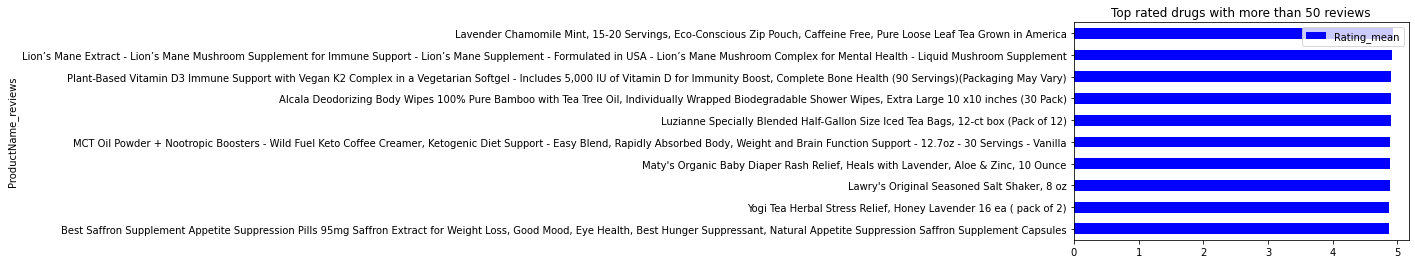

In [4]:
# Top 10 reviewed & rated medicinal products

top_products = reviews.groupby('ProductName_reviews').agg({'ReviewStar':['count','mean']}).reset_index()
top_products.columns = ['ProductName_reviews','Rating_count','Rating_mean']
top_reviewed = top_products.sort_values(by = 'Rating_count').tail(10)
top_rated = top_products[top_products.Rating_count>50].sort_values(by = ['Rating_mean']).tail(10)


top_reviewed.plot(kind='barh',y='Rating_count',x='ProductName_reviews',color='r',\
                 title = 'Top most reviewed drugs');


top_rated.plot(kind='barh',y='Rating_mean',x='ProductName_reviews',color='b',\
              title = 'Top rated drugs with more than 50 reviews');



In [5]:
reviews = reviews.sample(frac=0.02, replace=True, random_state=1)

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15785 entries, 128037 to 750397
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15785 non-null  int64  
 1   ASIN                   15785 non-null  object 
 2   ReviewId               15785 non-null  object 
 3   Keyword                15785 non-null  object 
 4   KeywordDept            15785 non-null  float64
 5   ProductFlavor_reviews  15785 non-null  object 
 6   ProductName_reviews    15785 non-null  object 
 7   ProductNumReviews      15785 non-null  int64  
 8   ReviewContent          15785 non-null  object 
 9   ReviewEarly            15785 non-null  int64  
 10  ReviewHelpful          15785 non-null  int64  
 11  ReviewStar             15785 non-null  float64
 12  ReviewTime             15785 non-null  object 
 13  ReviewVerifiedP        15785 non-null  int64  
 14  ReviewVine             15785 non-null  int64  
 

In [7]:
reviews.to_csv('sample_reviews.csv',index=False)

### Data Cleaning

Since the goal of this analysis is to perform topic modeling on customer reviews, we will solely focus on the review content data and drop other columns.

In [8]:
# Remove unnecessary columns
reviews = reviews[["ProductName_reviews", "ReviewContent"]]

#### Remove punctuation,lower casing, non ASCII characters

Next, we perform a simple preprocessing on the content of ReviewContent column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any non ASCII characters, punctuation, and then lowercase the text.

In [9]:
# Load the regular expression library
import re
import string

# Remove non ASCII characters
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

# Modify abbreviations
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

# Remove hyperlinks, puncuations, numbers, etc.
def remove_features(data_str):
    # compile regex
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
 
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    html_re = re.compile("<br />")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str =  re.sub(r'^https?:\/\/.*[\r\n]*', '', data_str, flags=re.MULTILINE)
    # remove @mentions
    data_str = re.sub(r"(?:\@|https?\://)\S+", "", data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove html symbol
    data_str = html_re.sub(' ', data_str)   
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    return " ".join(cleaned_str.split())


# Clean up the text
def clean_text(text):
    text = strip_non_ascii(text)
    text = fix_abbreviation(text)
    text = remove_features(text)
    return text
    
reviews['Review_Processed'] = reviews['ReviewContent'].apply(clean_text)
    
# Print out processed reviews
reviews.head()  

ProductName_reviews  \
128037  Calm Drops Stress & Anxiety Relief Supplement ...   
491755  Breville JE98XL Juice Fountain Plus 850-Watt J...   
470924  Weight Loss Drops - Made in USA - Best Diet Dr...   
491263  NatureWise Raspberry Ketones Plus | Advanced W...   
371403  ACURE Brightening Facial Scrub |100% Vegan |Fo...   

                                            ReviewContent  \
128037  I feel like the product works well. I can get ...   
491755  I love my Breville - it is the perfect size an...   
470924                             Excellent works great.   
491263  I like this product for the fact that it works...   
371403  Absolutely obsessed wit this!!! Texture is a s...   

                                         Review_Processed  
128037  feel like the product works well can get stres...  
491755  love my breville it is the perfect size and so...  
470924                              excellent works great  
491263  like this product for the fact that it works w...  
371403  absolutely obsessed wit this texture is slight...

#### Tokenize words and further filtering text

Let’s tokenize each sentence into a list of words, removing characters of length less than 3 and words less frequent (<10 times) in the document altogether.

In [10]:
import gensim
from gensim.utils import simple_preprocess

# Note that simple_preprocess by default delete tokens of length less than 2
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), min_len=3, deacc=True))  # deacc=True removes accent marks from tokens

# Create a list of processed reviews and 
data = reviews.Review_Processed.values.tolist()
data_words = list(sent_to_words(data))

In [11]:
print(data_words[0][:30])

['feel', 'like', 'the', 'product', 'works', 'well', 'can', 'get', 'stressed', 'out', 'between', 'managing', 'the', 'household', 'with', 'little', 'kids', 'running', 'around', 'the', 'taste', 'challenging', 'the', 'palate', 'feel', 'that', 'the', 'taste', 'improved', 'would']


#### Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. 

    min_count ignore all words and bigrams with total collected count lower than this. Bydefault it value is 5

    threshold represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold, where N is the total vocabulary size. Bydefault it value is 10.0



In [12]:
# Build the bigram Phrase object
bigram = gensim.models.Phrases(data_words, min_count=15, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Create a Phraser object
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [13]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['come','try','go','get','make','would','really','got']) # customerize with domain specific stopword

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /Users/btian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Define functions for stopwords, bigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB','ADV']): # exclude  
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Count the frequency of occurance of tokens

from collections import defaultdict 
import operator

def word_frequency(corpus=[[]]):
    """
    :param corpus: a list of lists representing tokenized documents
    :return: a dict containing the frequency of each word in the corpus
    """
    frequency = defaultdict(int)
    for doc in corpus:
        for w in doc:
            frequency[w] += 1
    return dict(sorted(frequency.items(), key=operator.itemgetter(1), reverse=True))

Let's call the functions in order.

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_all = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Filtering words based off of low frequency < 10 instances (mispellings, rare words) and removing
# high frequency words that don't provide a lot of discrimination between documents
freq = word_frequency(data_lemmatized_all)

data_lemmatized = [[token for token in doc if freq[token] > 10] for doc in data_lemmatized_all]

print(data_lemmatized[:1][0][:30])

['feel', 'product', 'work', 'well', 'stress', 'manage', 'household', 'little', 'kid', 'run', 'taste', 'challenge', 'feel', 'taste', 'improve', 'easily', 'give', 'star', 'reason', 'give', 'feel', 'work']


### Data transformation: corpus and dictionary

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2)]


## 3. LDA Model Traning
<a id='3'></a>

### Building the base topic model and find the number of topics 

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

Chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

Passes controls how often we train the model on the entire corpus (set to 20). 

Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [17]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus,
                       id2word=id2word,
                       num_topics=num_topics, 
                       random_state=100,
                       chunksize=500,
                       passes=20,
                       iterations = 400,
                       eval_every = 1,
                       alpha='symmetric',
                       eta=0.07)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

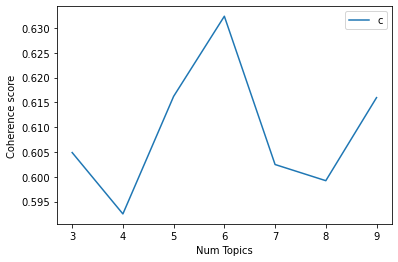

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
from pprint import pprint

# Print the Keyword in the 10 topics
lda = model_list[1]
pprint(lda.print_topics())
doc_lda = lda[corpus]

lda2 = model_list[3]
pprint(lda2.print_topics())
doc_lda2 = lda2[corpus]

lda3 = model_list[5]
pprint(lda3.print_topics())
doc_lda3 = lda3[corpus]

[(0,
  '0.050*"take" + 0.033*"help" + 0.026*"feel" + 0.026*"day" + 0.021*"work" + '
  '0.019*"product" + 0.019*"well" + 0.014*"sleep" + 0.014*"pain" + '
  '0.013*"use"'),
 (1,
  '0.100*"great" + 0.095*"product" + 0.040*"good" + 0.038*"work" + '
  '0.034*"love" + 0.025*"price" + 0.016*"use" + 0.015*"quality" + 0.014*"easy" '
  '+ 0.013*"give"'),
 (2,
  '0.057*"use" + 0.031*"product" + 0.030*"skin" + 0.017*"feel" + 0.016*"look" '
  '+ 0.016*"smell" + 0.013*"love" + 0.013*"time" + 0.012*"face" + '
  '0.012*"well"'),
 (3,
  '0.046*"taste" + 0.040*"tea" + 0.029*"good" + 0.021*"drink" + 0.020*"coffee" '
  '+ 0.019*"flavor" + 0.015*"water" + 0.014*"love" + 0.012*"buy" + '
  '0.011*"green"')]
[(0,
  '0.071*"take" + 0.037*"feel" + 0.036*"help" + 0.030*"product" + 0.030*"day" '
  '+ 0.020*"pain" + 0.019*"work" + 0.018*"energy" + 0.017*"supplement" + '
  '0.015*"well"'),
 (1,
  '0.115*"product" + 0.057*"great" + 0.052*"bottle" + 0.047*"love" + '
  '0.043*"order" + 0.030*"ingredient" + 0.021*"purc

### Investigate Results

In [21]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(model_list[1], corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.039279  0.229282       1        1  37.617065
2     -0.034709  0.120661       2        1  25.511774
3     -0.237035 -0.222667       3        1  20.949129
1      0.311023 -0.127276       4        1  15.922035, topic_info=           Term         Freq        Total Category  logprob  loglift
27        great  3916.000000  3916.000000  Default  30.0000  30.0000
9       product  7419.000000  7419.000000  Default  29.0000  29.0000
50         take  4598.000000  4598.000000  Default  28.0000  28.0000
14        taste  2360.000000  2360.000000  Default  27.0000  27.0000
112         tea  2076.000000  2076.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
182  definitely   364.406616  1054.190918   Topic4  -4.6727   0.7752
26          use   622.701660  5394.034180   Topic4  -4.1369  -0.3215
107         buy   400.251678  1669.126709   Topic4  -4.5788   0.4095
361       order   297.648407   981.117065   Topic4  -4.8750   0.6447
318        find   284.689728  1299.498657   Topic4  -4.9195   0.3191

[234 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
159       1  0.197399        add
159       3  0.801933        add
230       4  0.999670  advertise
63        1  0.998586    already
33        1  0.492165       also
...     ...       ...        ...
16        2  0.142664       work
16        4  0.373451       work
415       1  1.000823    workout
221       1  0.514697       year
221       2  0.484845       year

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(model_list[3], corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140433  0.095522       1        1  26.276329
2      0.131825  0.173480       2        1  18.225374
5      0.209554 -0.054171       3        1  15.767007
4     -0.068370 -0.107173       4        1  15.636478
3     -0.088214 -0.283834       5        1  14.471987
1     -0.325228  0.176177       6        1   9.622825, topic_info=          Term         Freq        Total Category  logprob  loglift
9      product  7432.000000  7432.000000  Default  30.0000  30.0000
50        take  4558.000000  4558.000000  Default  29.0000  29.0000
14       taste  2305.000000  2305.000000  Default  28.0000  28.0000
26         use  5395.000000  5395.000000  Default  27.0000  27.0000
112        tea  2028.000000  2028.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
90   recommend   252.945969  1139.369629   Topic6  -4.5342   0.8360
52        time   297.668152  2016.987793   Topic6  -4.3714   0.4277
219    vitamin   193.371353   548.899536   Topic6  -4.8028   1.2977
152       come   174.271240   534.898438   Topic6  -4.9068   1.2196
318       find   191.926178  1302.937744   Topic6  -4.8103   0.4258

[341 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
32        1  0.085795  absolutely
32        4  0.221638  absolutely
32        5  0.107244  absolutely
32        6  0.586268  absolutely
61        2  0.270981    actually
...     ...       ...         ...
16        4  0.094438        work
415       1  1.000147     workout
221       1  0.142997        year
221       2  0.779433        year
221       3  0.077541        year

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 5, 4, 2])

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(model_list[5], corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.021633  0.189477       1        1  26.552559
7      0.006817  0.076078       2        1  16.190710
4     -0.103902  0.085628       3        1  13.549437
3     -0.072916 -0.230430       4        1  11.231693
5     -0.063711  0.028167       5        1  10.020771
2     -0.279360 -0.039929       6        1   8.785620
6      0.229898 -0.260804       7        1   7.759017
1      0.304808  0.151813       8        1   5.910191, topic_info=            Term         Freq        Total Category  logprob  loglift
9        product  7220.000000  7220.000000  Default  30.0000  30.0000
27         great  3739.000000  3739.000000  Default  29.0000  29.0000
50          take  4567.000000  4567.000000  Default  28.0000  28.0000
14         taste  2292.000000  2292.000000  Default  27.0000  27.0000
16          work  3880.000000  3880.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
22          make   190.892914  1479.330444   Topic8  -4.3282   0.7809
799  improvement   129.928543   263.160248   Topic8  -4.7129   2.1227
301         want   139.618195   769.463745   Topic8  -4.6410   1.1217
517        right   132.849075   408.900879   Topic8  -4.6907   1.7042
145         even   133.349091  1006.839844   Topic8  -4.6869   0.8069

[446 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
406       3  0.995313    absorb
1069      2  0.994542      ache
61        2  0.341345  actually
61        4  0.156103  actually
61        5  0.503692  actually
...     ...       ...       ...
221       1  0.186855      year
221       2  0.518472      year
221       3  0.057494      year
221       5  0.156055      year
221       6  0.081108      year

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 5, 4, 6, 3, 7, 2])

In [24]:
# select and article at random from reviews
random_article_index = np.random.randint(len(reviews))

print(random_article_index)
print(reviews.iloc[random_article_index,1])

9436
Thought these packages would be bigger for this price. Taste is just OK. Value doesn’t align with price.


In [25]:
print(data_lemmatized[random_article_index])

['thought', 'package', 'big', 'price', 'taste', 'value', 'price']


In [26]:
dictionary = id2word
bow = dictionary.doc2bow(data_words[random_article_index])
lda.get_document_topics(bow=bow)

[(0, 0.04342586), (1, 0.37474948), (2, 0.042362012), (3, 0.5394626)]

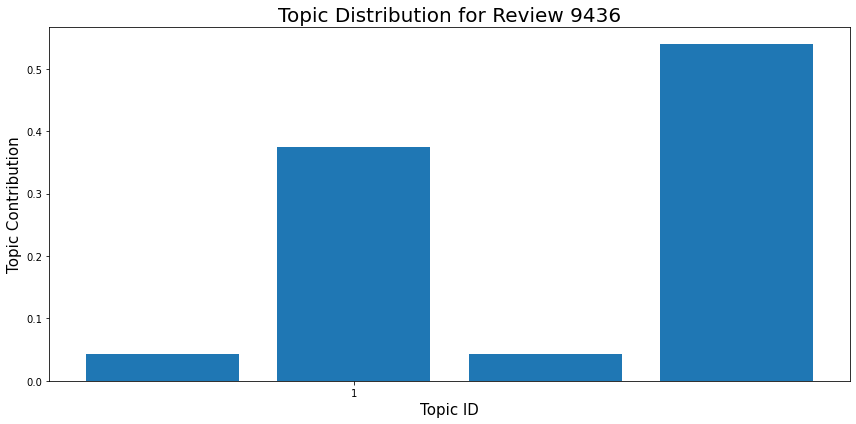

In [27]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Review " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,6,1))
fig.tight_layout()
plt.show()

In [28]:
lda2.get_document_topics(bow=bow)

[(0, 0.028032977),
 (1, 0.027780712),
 (2, 0.028076876),
 (3, 0.46836048),
 (4, 0.229166),
 (5, 0.21858294)]

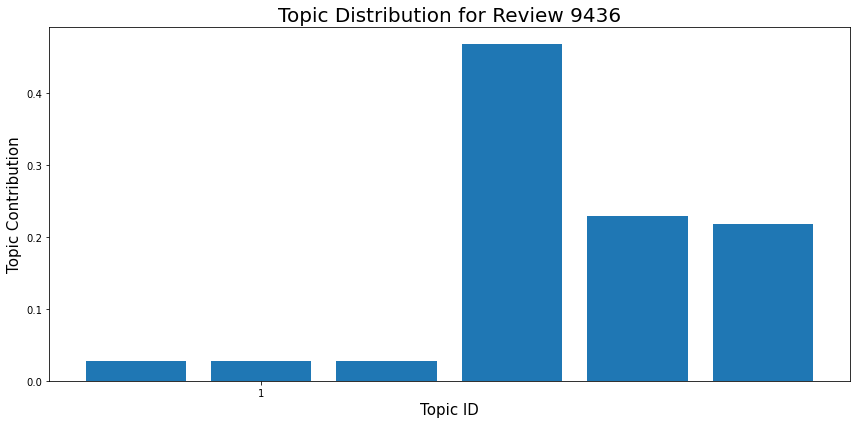

In [29]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda2.get_document_topics(bow=bow)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Review " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,6,1))
fig.tight_layout()
plt.show()

In [30]:
lda3.get_document_topics(bow=bow)

[(0, 0.18736275),
 (1, 0.020835815),
 (2, 0.35421425),
 (3, 0.18752313),
 (4, 0.18749785),
 (5, 0.020835811),
 (6, 0.020835815),
 (7, 0.020894567)]

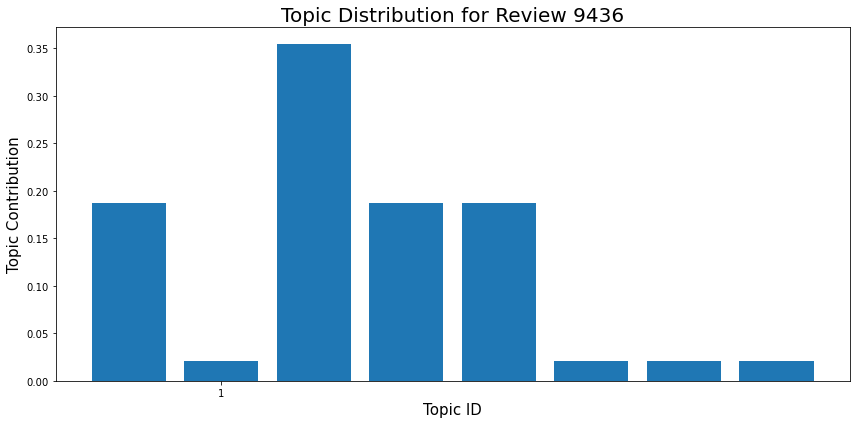

In [31]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda3.get_document_topics(bow=bow)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Review " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,6,1))
fig.tight_layout()
plt.show()

## 4. Effectiveness Filter
<a id='4'></a>

In [38]:
def effective_filter(text):
    text = clean_text(text)
    text = gensim.utils.simple_preprocess(text, min_len=3, deacc=True)
    text = [word for word in text if word not in stop_words]
    text = bigram_mod[text]
    text = nlp(" ".join(text))
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    text = [token.lemma_ for token in text if token.pos_ in allowed_postags]
    bow = dictionary.doc2bow(text)
    return lda2.get_document_topics(bow=bow)

In [46]:
# select and article at random from reviews
random_article_index = np.random.randint(len(reviews))
print(random_article_index)
text = reviews.iloc[random_article_index,1]
print(text)

14719
I ran 10 carrots through my Champion juicer and 10 carrots through the Breville. The Champion made a little more juice but the Breville juice tasted smoother. I think it is easy to clean. Just take a brush to the screen.


In [47]:
effective_filter(text)

[(0, 0.13666004),
 (1, 0.0151599515),
 (2, 0.29029614),
 (3, 0.17303741),
 (4, 0.36964184),
 (5, 0.015204599)]

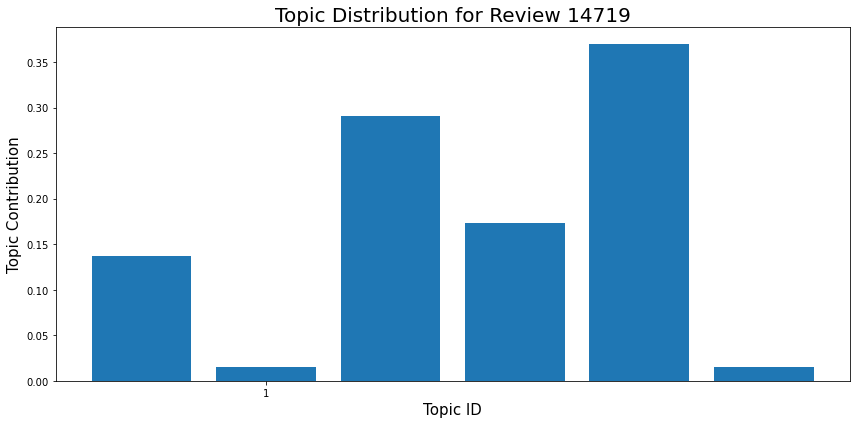

In [48]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in effective_filter(text)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Review " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,6,1))
fig.tight_layout()
plt.show()

In [49]:
def effect_score(text):
    score = effective_filter(text)[0][1] + effective_filter(text)[1][1] + effective_filter(text)[5][1]
    return score
print(effect_score(text))

0.1670263


In [50]:
def effectness_checker(text):
    if effect_score(text) >= 0.5:
        return True
    else:
        return False

In [51]:
print(effectness_checker(text))

False


## 5. Medicinal Food Recommender Systerm
<a id='5'></a>

In [ ]:
# read the drop list and filter the effective reviews to df

def simple_recommender_with_adj(n = 10,df = full_set):
    '''
    input:
    n - number of requested drugs
    df - data set to work with
    output - recommended top n treatment products
    '''
    # Adjustment for review age
    alpha =  df.year / df.groupby('condition').year.transform('max') 
    beta  =   (df.usefulCount/df.groupby('condition').usefulCount.transform('max')).fillna(0)
    
    # Normalizing back to 10 point scale
    df['rating_adj'] = (df.rating*alpha +beta)*10/(np.max(df.rating*alpha +beta)) 
    
    # Filter for conditions with at least three drugs & at least 5 reviews
    
    cond = df.groupby('condition').drugName.count()
    rev =  df.groupby('drugName').review.count()
    rec_set = df[(df.condition.isin(cond[cond>2].index))&(df.drugName.isin(rev[rev>5].index))]
    

    rec_set = rec_set.groupby(['condition','drugName']).rating_adj.mean().reset_index().\
                sort_values(by = ['condition', 'rating_adj'], ascending = False)
    final = rec_set.loc[rec_set.condition ==c,['drugName','rating_adj']].drop_duplicates().reset_index()
    
    return final.drugName.head(n)


## 6. Reference
<a id='6'></a>

In [ ]:
To be added.